In [1]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import wandb

import os
key = os.getenv('WANDB_KEY')
!wandb login $key



/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


wandb: Appending key for api.wandb.ai to your netrc file: /home/studio-lab-user/.netrc


In [25]:
# lightning data 
# load imagefolder
path='data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)'
import os
diseases = os.listdir(path+'/train')
# load pilow
from PIL import Image
class data(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.read_all_images()
    def read_all_images(self):
        images = []
        labels = []
        for i in os.listdir(self.path):
            labels.append(i)
            img_path = os.path.join(self.path, i)
            # load image
            img = Image.open(img_path)
            # transform image
            if self.transform:
                img = self.transform(img)
            images.append(img)
            
            # dataset
        self.dataset = list(zip(images, labels))
    

    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        return self.dataset[idx]
   

class LeafDataLoader(pl.LightningDataModule):
    def __init__(self,dataset_dir,batch_size=44, shuffle=False, num_workers=4):
        super().__init__()
        self.dataset_dir = dataset_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
       
       
    def setup(self, stage=None):
        self.train_dataset = torchvision.datasets.ImageFolder(self.dataset_dir+'/train',transform=torchvision.transforms.ToTensor())
        self.val_dataset = torchvision.datasets.ImageFolder(self.dataset_dir+'/valid',transform=torchvision.transforms.ToTensor())
        test_path = 'data/test/test'
        self.test_dataset = data(test_path,transform=torchvision.transforms.ToTensor())

        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=True)
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

dataloader  = LeafDataLoader(path)
dataloader.setup()

In [4]:
# cnn model
class ClassifierCNN(torch.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(256*16*16, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, num_classes),
        )
    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x.view(x.size(0), -1))
        return x
class ClassifierModel(pl.LightningModule):
    def __init__(self,model, num_classes=10,learning_rate=0.005):
        super().__init__()
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.model = model
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        acc = self.get_accuracy(y_hat, y)
        self.log('train_acc', acc)
        return loss
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            x, y = batch
            y_hat = self.forward(x)
            loss = torch.nn.functional.cross_entropy(y_hat, y)
            self.log('val_loss', loss)
            acc = self.get_accuracy(y_hat, y)
            self.log('val_acc', acc)
            return {'val_loss': loss}
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        return {'val_loss': avg_loss}
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        return {'test_loss': loss}
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        return {'test_loss': avg_loss}
    def get_accuracy(self, y_hat, y):
        _, y_hat = y_hat.max(dim=1)
        return (y_hat == y).float().mean()
    def configure_optimizers(self):
        # adamw optimizer with learning rate scheduling

        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler, # Changed scheduler to lr_scheduler
           'monitor': 'val_loss'
       }

# effcientnetv2
effnet=torchvision.models.efficientnet_b0(pretrained=True)
effnet.classifier[1] = torch.nn.Linear(1280, 38)
model = ClassifierModel(effnet, num_classes=38,learning_rate=0.0001)

In [8]:
# rich progress bar
from pytorch_lightning.callbacks import RichProgressBar

# import wandb
# run = wandb.init()
# artifact = run.use_artifact('ameerhamza0220/leaf_disease_classification/model-24rbn32p:v5', type='model')
# artifact_dir = artifact.download()
model = ClassifierModel(effnet, num_classes=38,learning_rate=0.0001)
model = ClassifierModel.load_from_checkpoint('./artifacts/model-24rbn32p:v5/model.ckpt')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [5]:
val_data = dataloader.val_dataloader()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
acc = 0
for i, (x, y) in enumerate(val_data):
    x = x.to(device)
    y = y.to(device)
    y_hat = model(x)
    acc += model.get_accuracy(y_hat, y)
acc /= val_data.__len__()
print(acc)

tensor(0.9848, device='cuda:0')


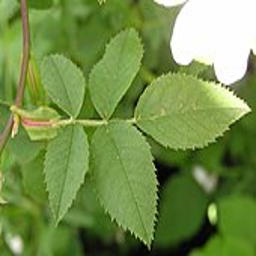

In [38]:
# download image from url
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Rosa_canina_blatt_2005.05.26_11.50.13.jpg/170px-Rosa_canina_blatt_2005.05.26_11.50.13.jpg'
import requests
from PIL import Image
from io import BytesIO
response = requests.get(url)
byte_img = BytesIO(response.content)
img = Image.open(byte_img)
img = img.resize((256,256))
# imshow jupyter
from IPython.display import display
display(img)

In [39]:
img = torchvision.transforms.ToTensor()(img)
img = img.unsqueeze(0)
img = img.to(device)
model.to(device)
model.eval()
y_hat = model(img)
_, y_hat = y_hat.max(dim=1)
print(y_hat)
print(diseases[y_hat])


tensor([14], device='cuda:0')
Grape___healthy


In [26]:
diseases

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_